In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [128]:
data = pd.read_csv("./Datasets/Paas Dataset.csv")
data.head()

,DateTime,APU
0,2023-01-01 00:00:00,3.43
1,2023-01-01 03:00:00,3.78
2,2023-01-01 06:00:00,4.23
3,2023-01-01 09:00:00,4.60
4,2023-01-01 12:00:00,3.60


In [129]:
data.columns

Index(['DateTime', 'APU'], dtype='object')

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  248 non-null    object 
 1   APU       248 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


<Axes: >

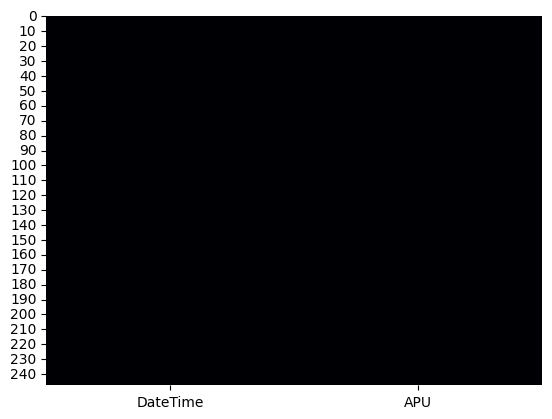

In [131]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False)

In [132]:
data.describe()

,APU
count,248.00
mean,6.22
std,1.64
min,3.33
25%,5.05
50%,6.21
75%,7.34
max,11.89


In [133]:
data = data.set_index('DateTime')

data.head()

,APU
DateTime,
2023-01-01 00:00:00,3.43
2023-01-01 03:00:00,3.78
2023-01-01 06:00:00,4.23
2023-01-01 09:00:00,4.60
2023-01-01 12:00:00,3.60


In [134]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [135]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

<Axes: title={'center': 'PaaS - Platform as a service'}, xlabel='DateTime', ylabel='APU'>

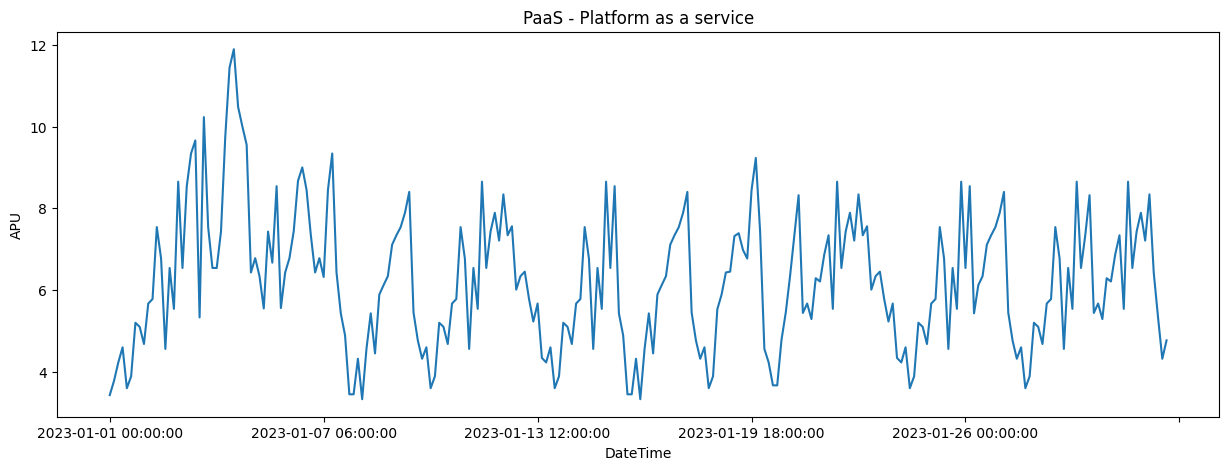

In [136]:
plt.figure(figsize = (15,5))
plt.title("PaaS - Platform as a service")
plt.ylabel("APU")
data[data.columns[0]].plot()

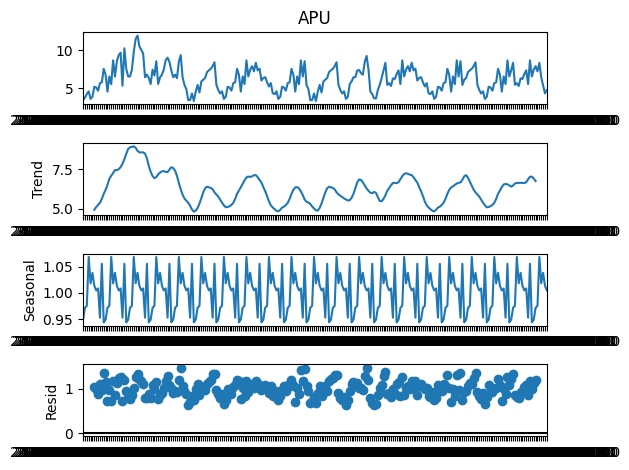

In [137]:
dec = sm.tsa.seasonal_decompose(data[data.columns[0]],period = 12, model = 'multiplicative').plot()
plt.show()

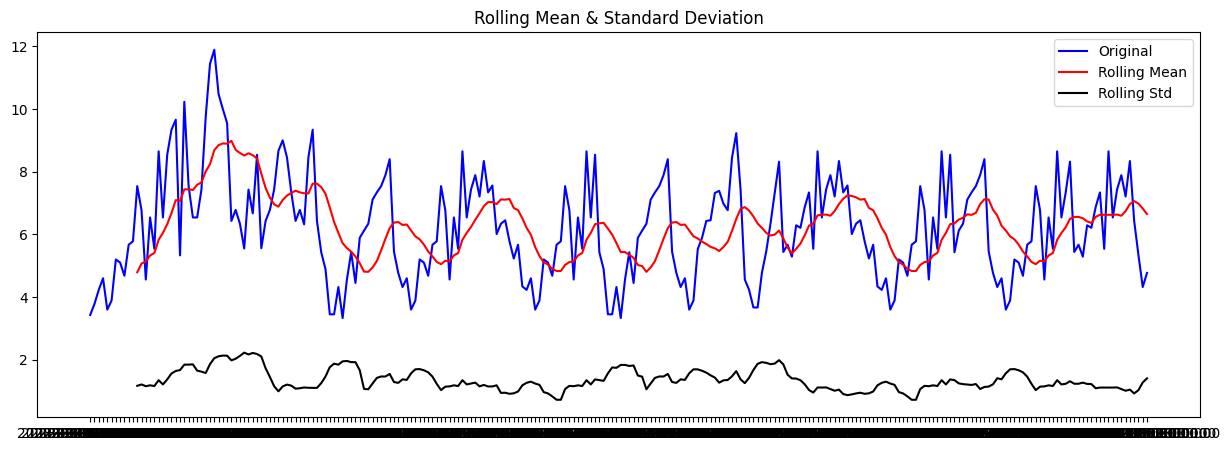

Results of Dickey-Fuller Test:
Test Statistic                 -5.74
p-value                         0.00
#Lags Used                      3.00
Number of Observations Used   244.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [138]:
test_stationarity(data[data.columns[0]])

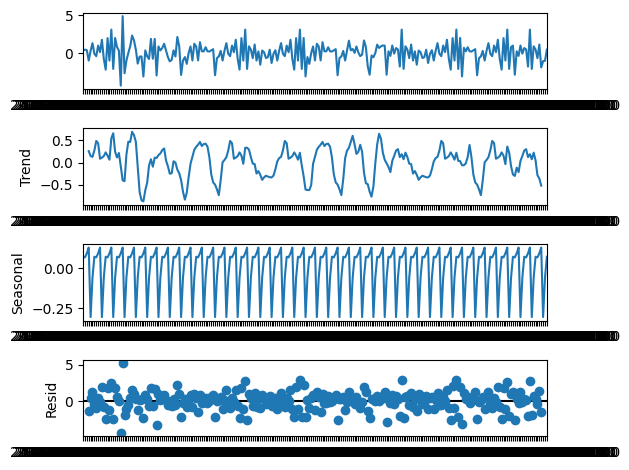

In [139]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 6).plot()
plt.show()

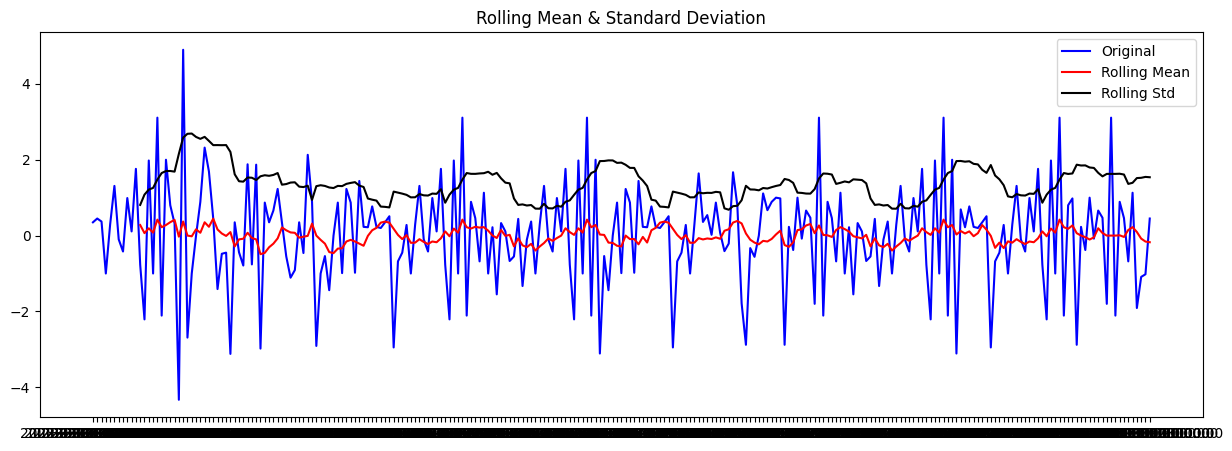

Results of Dickey-Fuller Test:
Test Statistic                 -6.84
p-value                         0.00
#Lags Used                     13.00
Number of Observations Used   233.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [140]:
test_stationarity(data_diff)

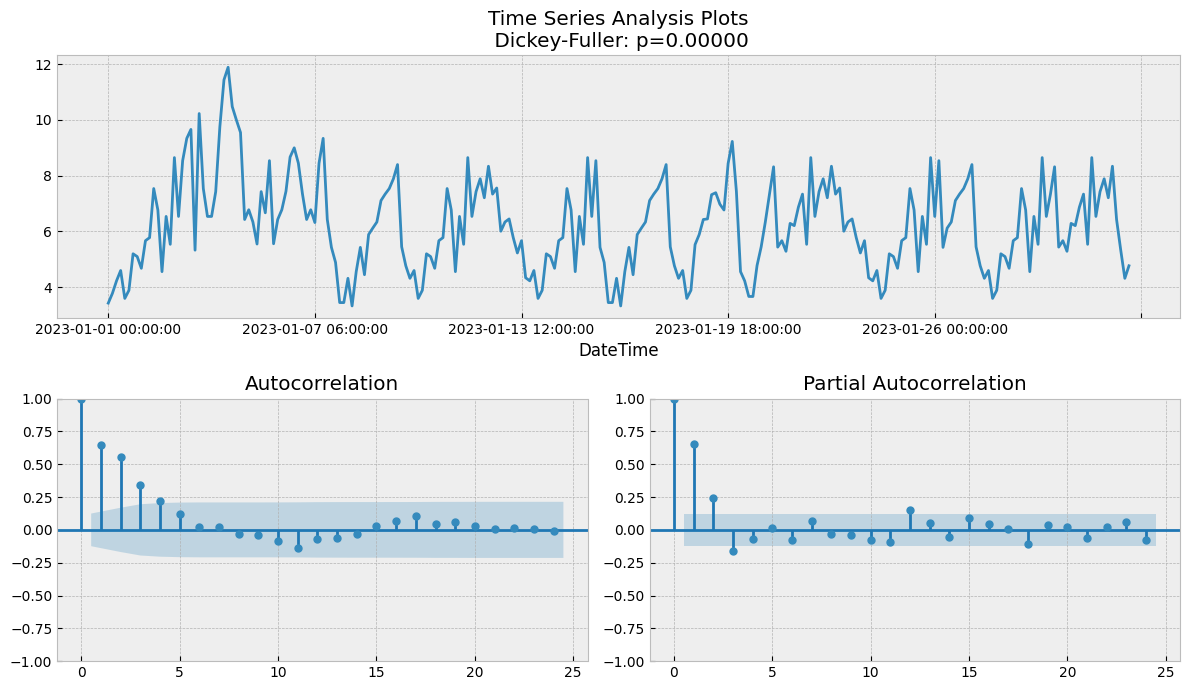

In [141]:
tsplot(data[data.columns[0]])

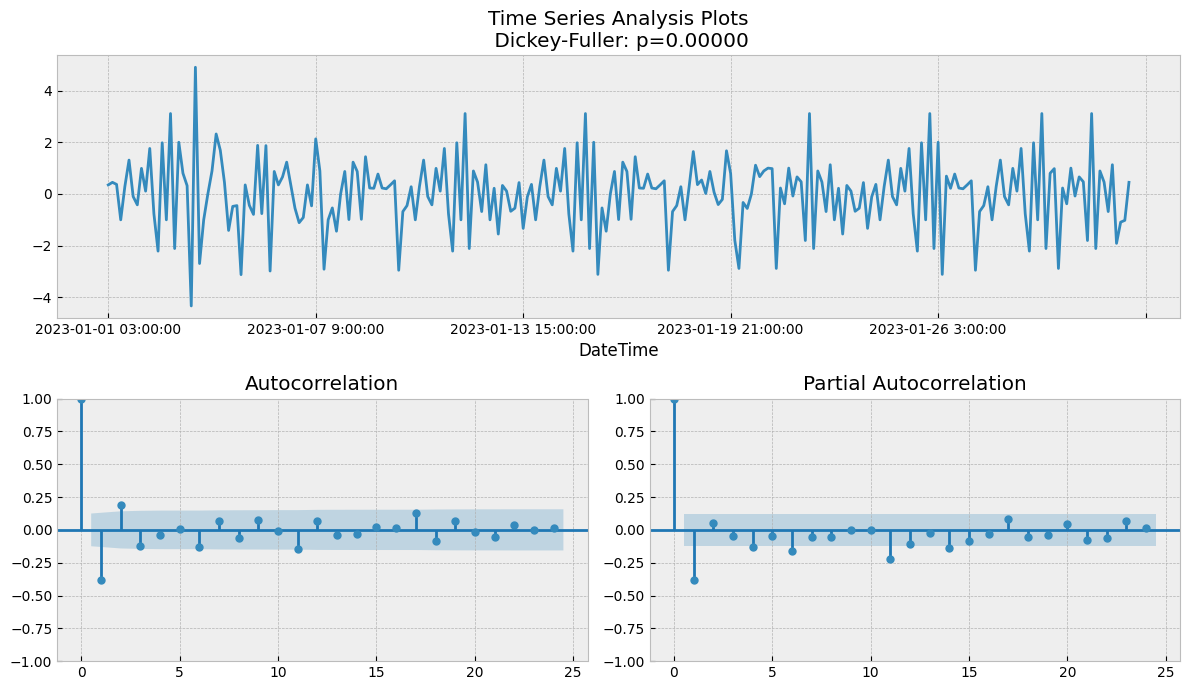

In [142]:
tsplot(data_diff[data.columns[0]])

In [143]:
model = ARIMA(data[data.columns[0]],order = (1,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    APU   No. Observations:                  248
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -410.273
Date:                Mon, 17 Apr 2023   AIC                            826.546
Time:                        15:14:21   BIC                            837.062
Sample:                    01-01-2023   HQIC                           830.781
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3752      0.055     -6.828      0.000      -0.483      -0.267
ma.L1         -0.9998      2.727     -0.367      0.714      -6.345       4.345
sigma2         1.6034      4.354      0.368      0.7

In [144]:
size = int(len(data) )
train, test = data[data.columns[0]][0:size], data[data.columns[0]][0:size]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 4.607417, expected = 3.430000
predicted = 3.935753, expected = 3.780000
predicted = 3.649308, expected = 4.230000
predicted = 4.064266, expected = 4.600000
predicted = 4.466602, expected = 3.600000
predicted = 3.977537, expected = 3.890000
predicted = 3.782651, expected = 5.200000
predicted = 4.716606, expected = 5.100000
predicted = 5.146006, expected = 4.680000
predicted = 4.843670, expected = 5.670000
predicted = 5.309580, expected = 5.780000
predicted = 5.750794, expected = 7.540000
predicted = 6.902804, expected = 6.770000
predicted = 7.075726, expected = 4.560000
predicted = 5.384281, expected = 6.540000
predicted = 5.811682, expected = 5.540000
predicted = 5.927568, expected = 8.650000
predicted = 7.486648, expected = 6.540000
predicted = 7.375903, expected = 8.540000
predicted = 7.779481, expected = 9.340000
predicted = 9.060286, expected = 9.660000
predicted = 9.568111, expected = 5.330000
predicted = 7.024278, expected = 10

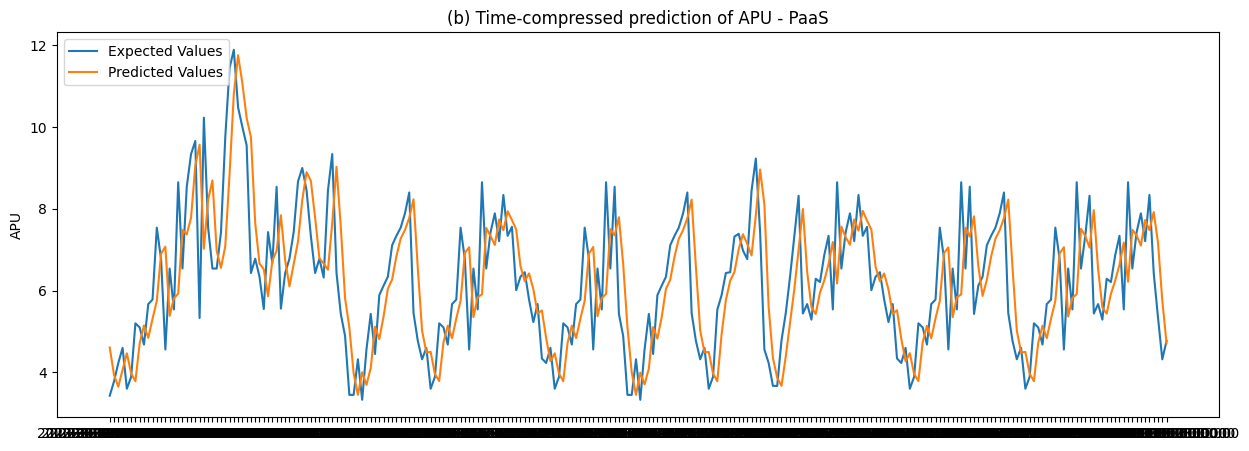

In [145]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data[data.columns[0]],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.title("(b) Time-compressed prediction of APU - PaaS")
plt.ylabel("APU")
plt.show()

In [146]:
error = np.sqrt(mean_squared_error(test,predictions))
error1 = np.sqrt(mean_absolute_error(test,predictions))
print('Test RMSE: %.4f' % error)
print('Test MAE: %.4f' % error1)

Test RMSE: 1.2673
Test MAE: 0.9990


In [173]:
from scipy.optimize import differential_evolution, LinearConstraint
import warnings
warnings.filterwarnings("ignore")
# Define the objective function as the cost of using the instances defined in Q
def objective_function(Q):
    # Define the cost and resources for each machine type
    machines = [
        {'name': 'Standard_DS1_v2', 'cores': 1, 'ram': 1, 'cost': 0.1},
        {'name': 'Standard_DS2_v2', 'cores': 2, 'ram': 2, 'cost': 0.2},
        {'name': 'Standard_DS3_v2', 'cores': 4, 'ram': 8, 'cost': 0.6},
        {'name': 'Standard_DS4_v2', 'cores': 8, 'ram': 16, 'cost': 0.8},
    ]
    # Calculate the total cost and resources for the given set of configurations Q
    total_cost = sum(Q[i] * machines[i]['cost'] for i in range(len(Q)))
    total_cores = sum(Q[i] * machines[i]['cores'] for i in range(len(Q)))
    total_ram = sum(Q[i] * machines[i]['ram'] for i in range(len(Q)))
    # Calculate the penalty for violating the resource constraints
    core_penalty = max(0, total_cores - required_cores)
    ram_penalty = max(0, total_ram - required_ram)
    # Return the total cost plus the penalty
    return total_cost + core_penalty + ram_penalty

# Define the bounds for the search space
bounds = [(-1, 12) for _ in range(4)] # Q_i can take values between 0 and 10
required_cores = 9
required_ram = 16

# Define the linear constraints for the resource constraints
machines = [
        {'name': 'Standard_DS1_v2', 'cores': 1, 'ram': 1, 'cost': 0.1},
        {'name': 'Standard_DS2_v2', 'cores': 2, 'ram': 2, 'cost': 0.2},
        {'name': 'Standard_DS3_v2', 'cores': 4, 'ram': 8, 'cost': 0.6},
        {'name': 'Standard_DS4_v2', 'cores': 8, 'ram': 16, 'cost': 0.8},
    ]
A = [[machines[i]['cores'] for i in range(len(machines))],
     [machines[i]['ram'] for i in range(len(machines))]]
# A = np.transpose(A)  # Transpose A to match the dimensions with Q
b = [required_cores, required_ram]
linear_constraint = LinearConstraint(A, b, b)

# Call the differential evolution function to minimize the objective function
result = differential_evolution(objective_function, bounds, constraints=linear_constraint)
optimal_configurations = []
cost = 0
for i in range(len(result.x)):
    if result.x[i] >= 1e-6:
        optimal_configurations.append(f"{int(round(result.x[i]))} instances of {machines[i]['name']}")
        if int(round(result.x[i])) > 0:
            cost+= float(machines[i]['cost'])
print("Optimal set of configurations: " + ", ".join(optimal_configurations))
print("Total Cost = ", cost)




Optimal set of configurations: 1 instances of Standard_DS1_v2, 0 instances of Standard_DS2_v2, 1 instances of Standard_DS4_v2
Total Cost =  0.9


In [163]:
#!/usr/bin/env python3
import requests
import json,time
from tabulate import tabulate 


def build_pricing_table(json_data, table_data):
    for item in json_data['Items']:
        meter = item['meterName']
        table_data.append([item['armSkuName'], item['retailPrice'], item['unitOfMeasure'], item['armRegionName'], meter, item['productName']])
        
def main():
    table_data = []
    table_data.append(['SKU', 'Retail Price', 'Unit of Measure', 'Region', 'Meter', 'Product Name'])
    
    api_url = "https://prices.azure.com/api/retail/prices?api-version=2021-10-01-preview"
    query = "serviceName eq 'Virtual Machines' and serviceFamily eq 'Compute' "
    response = requests.get(api_url, params={'$filter': query})
    json_data = json.loads(response.text)
    
    build_pricing_table(json_data, table_data)
    nextPage = json_data['NextPageLink']
    start_time = time.time()
    while(nextPage):
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > 60:
            break
        response = requests.get(nextPage)
        json_data = json.loads(response.text)
        nextPage = json_data['NextPageLink']
        build_pricing_table(json_data, table_data)
        
    print(tabulate(table_data, headers='firstrow', tablefmt='psql'))
    
if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [ ]:
from scipy.optimize import differential_evolution

# Define the objective function as the cost of using the instances defined in Q
def objective_function(Q):
    # Define the cost and resources for each machine type
    machines = [
        {'name': 'Standard_DS1_v2', 'cores': 1, 'ram': 3.5, 'cost': 0.1},
        {'name': 'Standard_DS2_v2', 'cores': 2, 'ram': 7, 'cost': 0.2},
        {'name': 'Standard_DS3_v2', 'cores': 4, 'ram': 14, 'cost': 0.4},
        {'name': 'Standard_DS4_v2', 'cores': 8, 'ram': 28, 'cost': 0.8},
    ]
    # Calculate the total cost and resources for the given set of configurations Q
    total_cost = sum(Q[i] * machines[i]['cost'] for i in range(len(Q)))
    total_cores = sum(Q[i] * machines[i]['cores'] for i in range(len(Q)))
    total_ram = sum(Q[i] * machines[i]['ram'] for i in range(len(Q)))
    # Calculate the penalty for violating the resource constraints
    core_penalty = max(0, total_cores - required_cores)
    ram_penalty = max(0, total_ram - required_ram)
    # Return the total cost plus the penalty
    return total_cost + core_penalty + ram_penalty

# Define the bounds and constraints for the search space
bounds = [(0, 10) for _ in range(4)] # Q_i can take values between 0 and 10
required_cores = 7
required_ram = 16
constraints = ({'type': 'eq', 'fun': lambda Q: sum(Q[i] * machines[i]['cores'] for i in range(len(Q))) - required_cores},
               {'type': 'eq', 'fun': lambda Q: sum(Q[i] * machines[i]['ram'] for i in range(len(Q))) - required_ram})

# Call the differential evolution function to minimize the objective function
result = differential_evolution(objective_function, bounds, constraints=constraints)

# Print the optimal set of configurations and the corresponding cost
optimal_configurations = [machines[i]['name'] for i in range(len(result.x)) if result.x[i] > 0]
print(f"Optimal set of configurations: {optimal_configurations}")
print(f"Corresponding cost: {result.fun}")
